In [1]:
# ! pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install tensorflow-probability
# ! pip install --upgrade tensorflow

In [2]:
# ! pip install --upgrade pandas yaml tensorflow tensorflow-probability ml-collections jraph

In [3]:
import sys, os
sys.path.append("../")

import pandas as pd
import yaml
import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict
from flax.training import train_state, checkpoints
from ml_collections.config_dict import ConfigDict
import numpy as vnp
import matplotlib.pyplot as plt
import tensorflow as tf

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm, sigma2, generate
from models.train_utils import create_input_iter, param_count, train_step
from datasets import load_data

EPS = 1e-7

%load_ext autoreload
%autoreload 2

## Dirs

In [27]:
data_dir = "/n/holyscratch01/iaifi_lab/ccuesta/data_for_sid/"

## My new runs
logging_dir = "/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
run_name = "divine-breeze-139"  # GNN
run_name = "magical-goosebump-109"  # Transformer

## Inference results

In [28]:
import sys
sys.path.append("../")

from datasets import get_nbody_data
x, _, conditioning, norm_dict = get_nbody_data(n_features=7, n_particles=5000, split="test")

## Load cluster run

In [29]:
config_file = "{}/{}/config.yaml".format(logging_dir, run_name)

with open(config_file, 'r') as file:
    config = yaml.safe_load(file)
    
config = ConfigDict(config)

In [30]:
# Load the dataset
train_ds, norm_dict = load_data(
        config.data.dataset,
        config.data.n_features,
        config.data.n_particles,
        32,
        config.seed,
        shuffle=True,
        split="test",
        #**config.data.kwargs,
    )

batches = create_input_iter(train_ds)

In [31]:
config.data

add_augmentations: true
add_rotations: true
add_translations: true
box_size: 1000.0
conditioning_parameters:
- Omega_m
- sigma_8
dataset: nbody
kwargs: {}
n_features: 7
n_particles: 5000
n_pos_features: 3
simulation_set: lhc

In [32]:
config.training

batch_size: 16
eval_every_steps: 5000
half_precision: false
log_every_steps: 100
n_train_steps: 301000
p_uncond: 0.0
save_every_steps: 5000
unconditional_dropout: false
warmup_steps: 5000

In [61]:
x, conditioning, mask = next(batches)
x = x.reshape(-1, config.data.n_particles, config.data.n_features)
conditioning = conditioning.reshape(-1, 2)
mask = mask.reshape(-1, config.data.n_particles)

In [63]:
# Diffusion model
x_mean = tuple(map(float, norm_dict["mean"]))
x_std = tuple(map(float, norm_dict["std"]))
config.data.apply_pbcs = False
box_size = config.data.box_size #if config.data.apply_pbcs else None
unit_cell = tuple(map(tuple, config.data.unit_cell)) if config.data.apply_pbcs else None

norm_dict_input = FrozenDict(
    {
        "x_mean": x_mean,
        "x_std": x_std,
        "box_size": box_size,
        "unit_cell": unit_cell,
    }
)

In [64]:
print("{} devices visible".format(jax.device_count()))

# Score and (optional) encoder model configs
score_dict = FrozenDict(config.score)
encoder_dict = FrozenDict(config.encoder)
decoder_dict = FrozenDict(config.decoder)

# Diffusion model
vdm = VariationalDiffusionModel(
        d_feature=config.data.n_features,
        timesteps=config.vdm.timesteps,
        noise_schedule=config.vdm.noise_schedule,
        # noise_schedule="linear",
        noise_scale=config.vdm.noise_scale,
        d_t_embedding=config.vdm.d_t_embedding,
        gamma_min=config.vdm.gamma_min,
        gamma_max=config.vdm.gamma_max,
        score=config.score.score,
        score_dict=score_dict,
        embed_context=config.vdm.embed_context,
        d_context_embedding=config.vdm.d_context_embedding,
        n_classes=config.vdm.n_classes,
        use_encdec=config.vdm.use_encdec,
        encoder_dict=encoder_dict,
        decoder_dict=decoder_dict,
        norm_dict=norm_dict_input,
)

# Pass a test batch through to initialize model
x_batch, conditioning_batch, mask_batch = next(batches)
rng = jax.random.PRNGKey(42)
_, params = vdm.init_with_output({"sample": rng, "params": rng}, x_batch[0], conditioning_batch[0], mask_batch[0])

print(f"Params: {param_count(params):,}")

# Training config and state
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0, peak_value=config.optim.learning_rate, warmup_steps=config.training.warmup_steps, decay_steps=config.training.n_train_steps)
tx = optax.adamw(learning_rate=schedule, weight_decay=config.optim.weight_decay)
if hasattr(config.optim, "grad_clip"):
    if config.optim.grad_clip is not None:
        tx = optax.chain(
            optax.clip(config.optim.grad_clip),
            tx,
        )

state = train_state.TrainState.create(apply_fn=vdm.apply, params=params, tx=tx)

4 devices visible
Params: 4,776,281


In [65]:
ckpt_dir = "{}/{}/".format(logging_dir, run_name)  # Load SLURM run
restored_state = checkpoints.restore_checkpoint(ckpt_dir=ckpt_dir, target=state, step=295000)

if state is restored_state:
    raise FileNotFoundError(f"Did not load checkpoint correctly")

## Generate and evaluate simulations

In [66]:
n_samples = 2
idx_rnd = vnp.random.choice(vnp.arange(len(x)), size=n_samples, replace=False)

cond_gen = conditioning[idx_rnd]
mask_gen = mask[idx_rnd]

rng, _ = jax.random.split(rng)

x_samples = generate(vdm, restored_state.params, rng, (n_samples, config.data.n_particles), conditioning=cond_gen, mask=mask_gen, steps=500)
x_samples = x_samples.mean()

Text(0.5, 0, 'z')

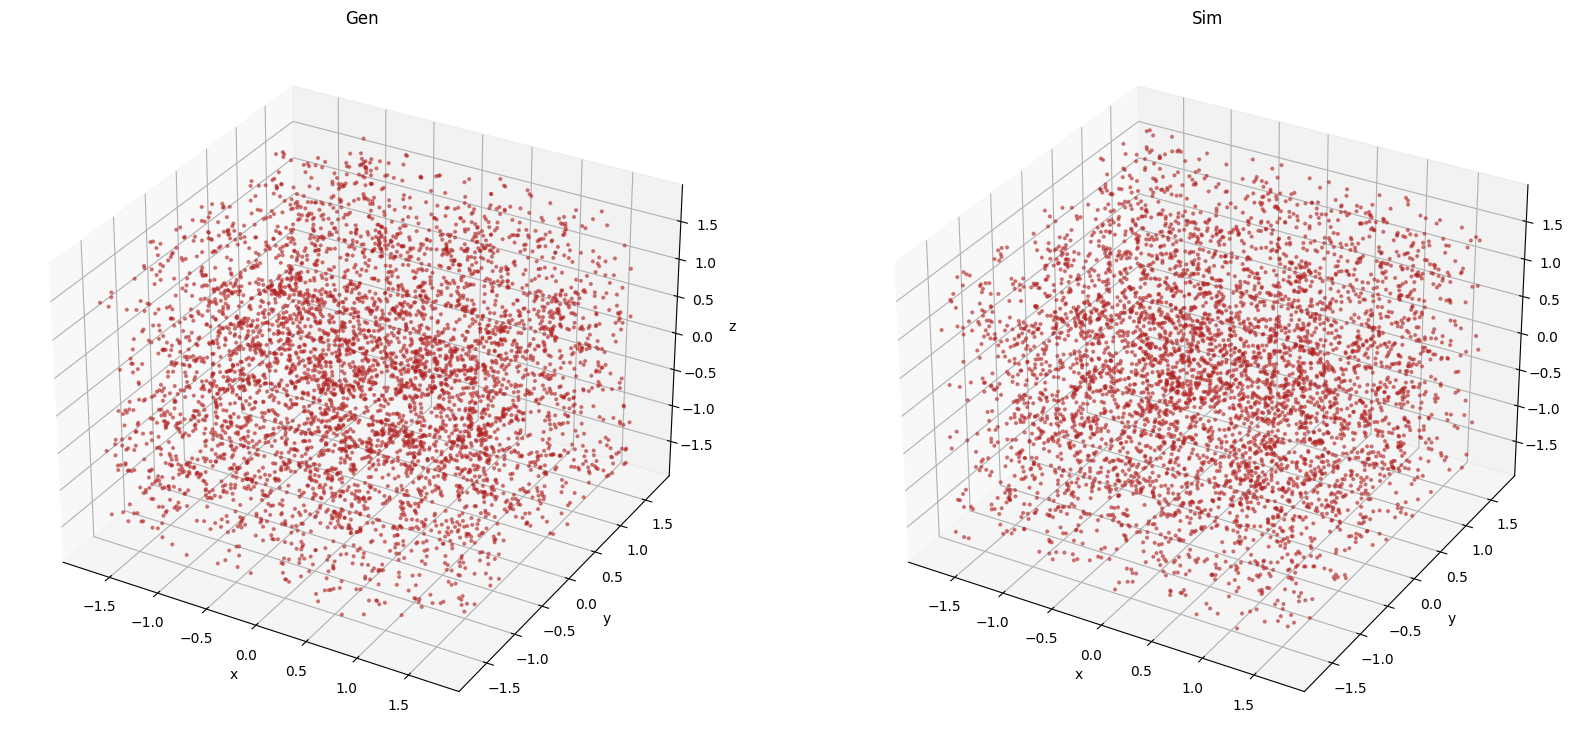

In [67]:
idx = 0

s = 4
alpha = 0.5
color = "firebrick"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), subplot_kw={'projection':'3d'})

ax1.scatter(x_samples[idx, :, 0], x_samples[idx, :, 1], x_samples[idx, :, 2], alpha=alpha, s=s, color=color);
ax1.set_title("Gen")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")

ax2.scatter(x[idx_rnd[idx], :, 0], x[idx_rnd[idx], :, 1], x[idx_rnd[idx], :, 2], alpha=alpha, s=s, color=color);
ax2.set_title("Sim")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")

## Likelihood eval

In [68]:
from functools import partial

In [69]:
def elbo(vdm, params, rng, x, conditioning, mask, steps=20, T=1., unroll_loop=True):
    rng, spl = jax.random.split(rng)
    cond = vdm.apply(params, conditioning, method=vdm.embed)
    f = vdm.apply(params, x, conditioning, method=vdm.encode)
    loss_recon = vdm.apply(params, x, f, conditioning, rngs={"sample": rng}, method=vdm.recon_loss)
    loss_klz = vdm.apply(params, f, method=vdm.latent_loss)
    
    if not unroll_loop:

        def body_fun(i, val):
            loss, rng = val
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]) * T, f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            return (loss + (new_loss * mask[..., None]).sum((-1, -2)) / steps, rng)

        loss_diff, rng = jax.lax.fori_loop(0, steps, body_fun, (np.zeros(x.shape[0]), rng))

    else:
        
        loss_diff, rng = (np.zeros(x.shape[0]), rng)

        for i in range(steps):
            rng, spl = jax.random.split(rng)
            new_loss = vdm.apply(params, np.array([i / steps]) * T, f, cond, mask, rngs={"sample": spl}, method=vdm.diffusion_loss)
            loss_diff =  loss_diff + (new_loss * mask[..., None]).sum((-1, -2)) / steps

    # return ((loss_recon * mask[..., None]).sum((-1, -2)) + (loss_klz * mask[..., None]).sum((-1, -2)) + loss_diff)
    return ((loss_klz * mask[..., None]).sum((-1, -2)) + loss_diff)


In [70]:
@jax.jit
def likelihood(theta_test, x_test, n_samples=1, steps=20, T=1.0):
    x_test = np.repeat(np.array([x_test]), n_samples, 0)
    theta_test = np.repeat(np.array([theta_test]), n_samples, 0)
    return -elbo(vdm, restored_state.params, rng, x_test, theta_test, np.ones_like(x_test[..., 0]), steps=steps, T=T).mean()

In [71]:
idx = 16

x_test = x[idx]

Omega_m = conditioning[idx][0]
sigma_8 = conditioning[idx][1]

theta_test = np.array([Omega_m, sigma_8])
likelihood(theta_test, x_test)

Array(-232574.17, dtype=float32)

In [72]:
sigma_8_ary = np.linspace(0.6, 1.0, 40)

log_like = []

for sigma_8 in tqdm(sigma_8_ary):
    theta_test = np.array([conditioning[idx][0], sigma_8])
    log_like.append(likelihood(theta_test, x_test))

100%|█████████████████████████| 40/40 [00:08<00:00,  4.80it/s]


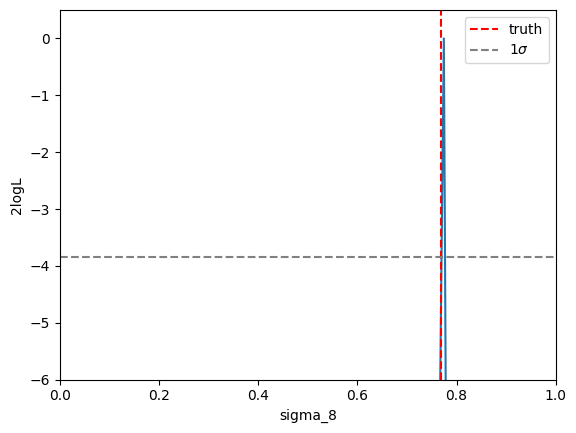

In [73]:
from scipy.stats import chi2

plt.plot(sigma_8_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][-1], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"sigma_8")

plt.legend()

In [74]:
omega_m_ary = np.linspace(0.1, 0.5, 40)

log_like = []

for omega_m in tqdm(omega_m_ary):
    theta_test = np.array([omega_m, conditioning[idx][1]])
    log_like.append(likelihood(theta_test, x_test))

100%|█████████████████████████| 40/40 [00:08<00:00,  4.80it/s]


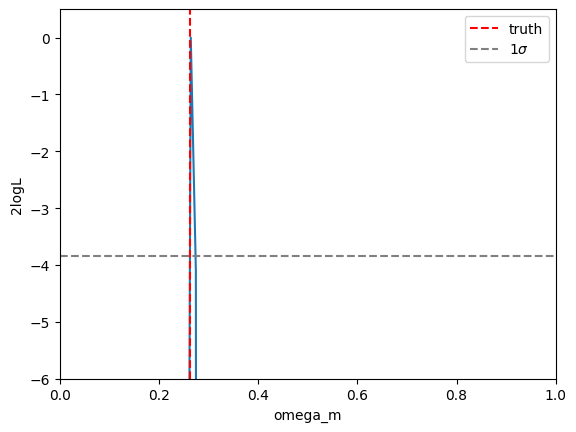

In [75]:
from scipy.stats import chi2

plt.plot(omega_m_ary, 2 * (np.array(log_like) - np.max(np.array(log_like))))
plt.axvline(conditioning[idx][0], ls='--', label="truth", color='red')
plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()

In [76]:
n_test = 32

log_like_cov = []
for idx in tqdm(range(n_test)):
    log_like = []
    x_test = x[idx]
    for omega_m in omega_m_ary:
        theta_test = np.array([omega_m, conditioning[idx][1]])
        log_like.append(likelihood(theta_test, x_test))
    log_like_cov.append(log_like)
log_like_cov = np.array(log_like_cov)

100%|█████████████████████████| 32/32 [04:31<00:00,  8.48s/it]


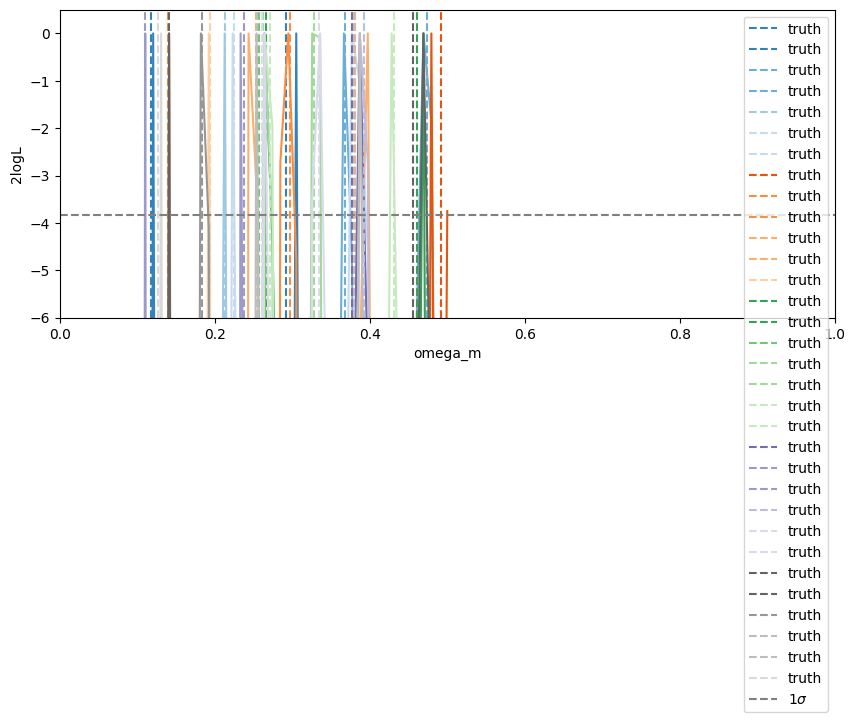

In [79]:
plt.figure(figsize=(10, 4))

i_ = 0
n_test_max = 32
for ic, idx in enumerate(range(i_,i_ + n_test_max)):
    if conditioning[idx][0] > 0.1:
        plt.plot(omega_m_ary, 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx]))), color=plt.cm.tab20c(ic / n_test_max))
        plt.axvline(conditioning[idx][0], ls='--', label="truth", color=plt.cm.tab20c(ic / n_test_max))

plt.xlim(0, 1)
plt.ylim(-6, 0.5)

plt.axhline(-chi2.isf(1 - .95, 1), ls = '--', color='grey', label="$1\sigma$")

plt.ylabel(r"2logL")
plt.xlabel(r"omega_m")

plt.legend()

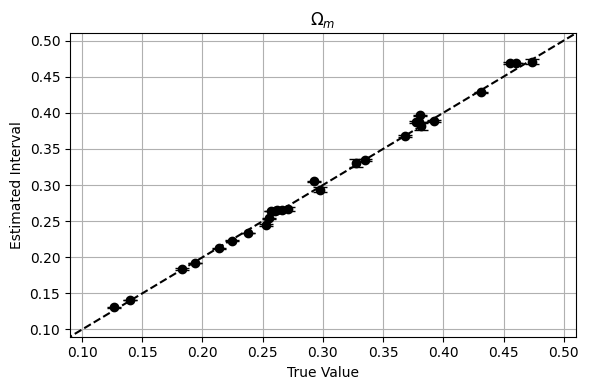

In [80]:
from scipy.interpolate import interp1d

i_ = 0
n_test_max = 32
threshold_1sigma = -chi2.isf(1 - .68, 1)

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    if conditioning[idx][0] < 0.12 or conditioning[idx][0] > 0.48:
        continue
        
    likelihood_arr = 2 * (np.array(log_like_cov[idx]) - np.max(np.array(log_like_cov[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(omega_m_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(omega_m_ary[0], omega_m_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][0])
    else:
        # Handle the case where no interval is found
        if len(sign_changes1) == 1:
            if x_vals[sign_changes1[0]] > 0.3:
                intervals1.append((x_vals[sign_changes1[0]], omega_m_ary[-1]))
                true_values.append(conditioning[idx][0])
            else:
                intervals1.append((omega_m_ary[0], x_vals[sign_changes1[0]]))
                true_values.append(conditioning[idx][0])
        else:
            pass
        

# Plotting true value vs. interval
plt.figure(figsize=(6, 4))

for value, (low, high) in zip(true_values, intervals1):
    plt.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k')

plt.plot([0,1],[0,1], color='k', ls='--')

plt.xlim(0.09, 0.51)
plt.ylim(0.09, 0.51)

plt.title("$\Omega_m$")

plt.xlabel("True Value")
plt.ylabel("Estimated Interval")
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
n_test = 32

log_like_cov_s8 = []
for idx in tqdm(range(n_test)):
    log_like = []
    x_test = x[idx]
    for sigma_8 in sigma_8_ary:
        theta_test = np.array([conditioning[idx][0], sigma_8])
        log_like.append(likelihood(theta_test, x_test))
    log_like_cov_s8.append(log_like)
log_like_cov_s8 = np.array(log_like_cov_s8)

100%|█████████████████████████| 32/32 [04:31<00:00,  8.48s/it]


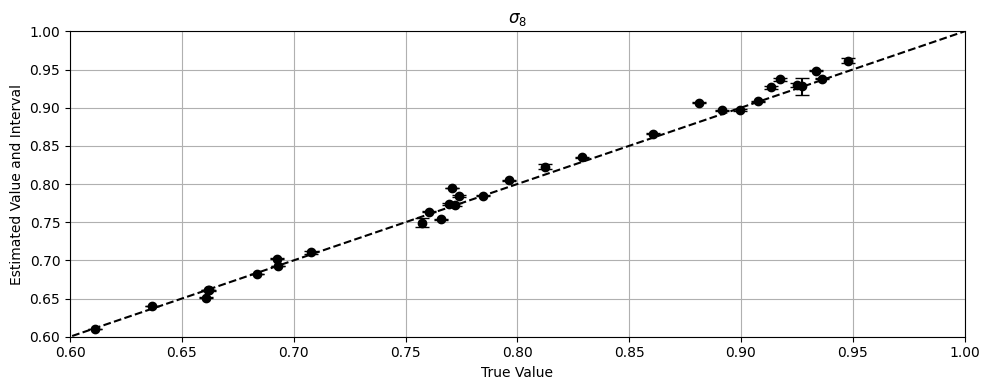

In [82]:
from scipy.interpolate import interp1d

i_ = 0
n_test_max = 32
threshold_1sigma = -chi2.isf(1 - .68, 1)
threshold_2sigma = -chi2.isf(1 - .95, 1)

intervals1 = []  # store intervals here
true_values = []  # store true values here

for ic, idx in enumerate(range(i_, i_ + n_test_max)):
    # if conditioning[idx][0] > 0.1:
    likelihood_arr = 2 * (np.array(log_like_cov_s8[idx]) - np.max(np.array(log_like_cov_s8[idx])))

    # Interpolate to find the 95% limits
    f_interp1 = interp1d(sigma_8_ary, likelihood_arr - threshold_1sigma, kind='linear', fill_value="extrapolate")
    f_interp2 = interp1d(sigma_8_ary, likelihood_arr - threshold_2sigma, kind='linear', fill_value="extrapolate")
    x_vals = np.linspace(sigma_8_ary[0], sigma_8_ary[-1], 1000)
    diff_signs1 = np.sign(f_interp1(x_vals))
    diff_signs2 = np.sign(f_interp2(x_vals))

    # Find where the sign changes
    sign_changes1 = ((diff_signs1[:-1] * diff_signs1[1:]) < 0).nonzero()[0]

    if len(sign_changes1) >= 2:  # We need at least two crossings
        intervals1.append((x_vals[sign_changes1[0]], x_vals[sign_changes1[-1]]))
        true_values.append(conditioning[idx][1])
    else:
        # Optionally handle the case where no interval is found
        pass

# Plotting true value vs. interval
plt.figure(figsize=(10, 4))

for value, (low, high) in zip(true_values, intervals1):
    plt.errorbar(value, (low + high) / 2., yerr=[[(low + high) / 2. - low], [high - (low + high) / 2.]], fmt='o', capsize=5, color='k')

plt.plot([0,1],[0,1], color='k', ls='--')

plt.xlim(0.6, 1.)
plt.ylim(0.6, 1.)

plt.title("$\sigma_8$")

plt.xlabel("True Value")
plt.ylabel("Estimated Value and Interval")
plt.grid(True)
plt.tight_layout()
plt.show()

In [86]:
np.savez("data/ll_profs_vel.npz",
         log_like_cov=log_like_cov,
         log_like_cov_s8=log_like_cov_s8,
         sigma_8_ary=sigma_8_ary,
         omega_m_ary=omega_m_ary,
         conditioning=conditioning)